## Analyzing historical demand and predicting sales using Machine Learning

Capstone project for Intermediate Data Science

Sumithra Candasamy

### The Project

Predict the sales based on historical demand and holiday events for 45 stores located in different regions. Each store contains many departments and there is a need to project the sales for each department in each store. 

This project investigates the application data sets and creates models that predict the sales for future timeframe. Based on this information, the client will be able to make better inventory handling decisions.

### The Data

The data that we have for this project is taken from the Kaggle website. The stores information, training and test data and features data is available to use.

-  _stores.csv_

> This file contains anonymized information about the 45 stores, indicating the type and size of store.

-  _train.csv_

> This is the historical training data, which covers to 2010-02-05 to 2012-11-01. Within this file you will find the following fields
- the store number
- the department number
- the weekly date
-  sales for the given department in the given store
- whether the week is a special holiday week


- test.csv

> This file is identical to train.csv, except we have withheld the weekly sales. You must predict the sales for each triplet of store, department, and date in this file.

- features.csv

> This file contains additional data related to the store, department, and regional activity for the given dates. It contains the following fields:
- the store number
- the week
- average temperature in the region
- cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.
- CPI - the consumer price index
- Unemployment - the unemployment rate
- IsHoliday - whether the week is a special holiday week
> For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):
> Super Bowl: 12-Feb-10, 11-Feb-11, 10-Feb-12, 8-Feb-13
> Labor Day: 10-Sep-10, 9-Sep-11, 7-Sep-12, 6-Sep-13
> Thanksgiving: 26-Nov-10, 25-Nov-11, 23-Nov-12, 29-Nov-13
> Christmas: 31-Dec-10, 30-Dec-11, 28-Dec-12, 27-Dec-13

### Methodology

I have used the forecasting procedures (FBProphet and ARIMA) that are used to forecast time series data.

**Prophet** is a procedure for forecasting time series data. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays. It works best with daily periodicity data with at least one year of historical data. Prophet is robust to missing data, shifts in the trend, and large outliers.

In time series analysis, an autoregressive integrated moving average (**ARIMA**) model is a generalization of an autoregressive moving average (ARMA) model. Both ARMA and ARIMA models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity.

### Libraries

pandas for :
-  data loading, wrangling, cleaning and manipulation
-  feature selection and engineering
-  description statistics

numpy for:
- array data structure, matrix manipulation    

matplotlib for:
- data visualization

scikit-learn for:
- model evaluation

### Data Loading, Wrangling and EDA

The data is in the form of CSV files, which are easily loaded into pandas dataframes. All the data is read as their respective datatype (int, float, bool), and the dates are parsed as dates automatically. Sales for some of weeks is missing in the train csv, and these are filled with 0.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import collections
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [2]:
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [3]:
## Load files from csv
weekly_sales_df = pd.read_csv('train.csv', header=0, parse_dates=['Date'])

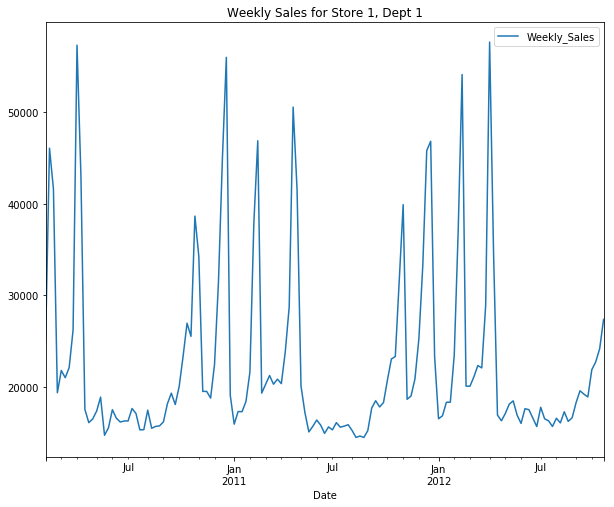

In [6]:
fig1 = weekly_sales_df[(weekly_sales_df['Store']==1) & (weekly_sales_df['Dept']==1)][['Date', 'Weekly_Sales']]
fig1.set_index(['Date'])[['Weekly_Sales']].plot(figsize=(10,8), title='Weekly Sales for Store 1, Dept 1')

### Feature Selection and Engineering

Since the dataset contains the historical sales for 45 stores in 81 departments, I have used this information, along with the holidays. This showed the seasonality of the sales in different store/department combinations.

In [12]:
## Create holiday df with lower and upper window = 0, as we do not want to extend the holiday out
# to days around the given date
def create_holidays_df():
    presidentsday_df = pd.DataFrame({
        'holiday': 'PresidentsDay',
        'ds': pd.to_datetime(['2/12/2010','2/11/2011','2/10/2012']),
        'lower_window': 0,
        'upper_window': 0
        })

    laborday_df = pd.DataFrame({
        'holiday': 'LaborDay',
        'ds': pd.to_datetime(['9/10/2010','9/9/2011','9/7/2012']),
        'lower_window': 0,
        'upper_window': 0
        })

    thanksgiving_df = pd.DataFrame({
        'holiday': 'LaborDay',
        'ds': pd.to_datetime(['11/26/2010','11/25/2011']),
        'lower_window': 0,
        'upper_window': 0
        })

    newyears_df = pd.DataFrame({
        'holiday': 'NewYearDay',
        'ds': pd.to_datetime(['12/31/2010','12/30/2011']),
        'lower_window': 0,
        'upper_window': 0
        })
    holidays_df = pd.concat((presidentsday_df, laborday_df, thanksgiving_df, newyears_df))
    return holidays_df

### Model Fitting

### Prophet

Prophet model is used with holidays information and yearly seasonality. The data was split into train and test sets, and the model was applied to the train set. The model was then used to define future timeframes to include the length of test set. The predict method is used to forecast for the future timeframe. 

In [13]:
## Define a function use Prophet model on the training set, and get the model, forecast, rmse and mae
def model_forecast_prophet(sales_df, stores, depts):    
    
    results_dict = collections.defaultdict(list)
    
    # create holidays/promotions events df
    holidays_df = create_holidays_df()              
    
    for store in stores:
        for dept in depts:
            df_str_dept = sales_df[(sales_df['Store']==store) & (sales_df['Dept']==dept)][['Date', 'Weekly_Sales']]            
            df_str_dept = df_str_dept.rename(columns={'Date': 'ds', 'Weekly_Sales': 'y'}) #rename the cols as needed by fbprophet            
            df_str_dept = df_str_dept.reset_index().drop('index',axis=1)
            
            ##Split df into train and test data as 70/30 of df
            train_size = int(len(df_str_dept) * 0.70)
            train_df = df_str_dept[0:train_size]
            test_df = df_str_dept[train_size:len(df_str_dept)]
            
            # Instantiate Prophet and include holiday effects & yearly_seasonality 
            #as our data follows yearly seasonal pattern
            model = Prophet(holidays=holidays_df, yearly_seasonality=True, 
                    weekly_seasonality=False, daily_seasonality=False) 
            model.add_seasonality(name='yearly', period='365.25', fourier_order=7)
            model.fit(train_df)
    
            # Define future timeframe, with len of test_df
            future = model.make_future_dataframe(periods=len(test_df), freq='W-FRI') 
    
            # Use predict method to forecast for the future timeframe
            forecast = model.predict(future)    
            
            #metrics - create df of predicted data and original data in test_df
            metrics_df = (forecast.set_index('ds')[['yhat']][test_df.index[0]:]).join(test_df.set_index('ds').y).reset_index()
            mse = mean_squared_error(metrics_df.y, metrics_df.yhat)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(metrics_df.y, metrics_df.yhat)
            
            results_dict[(store, dept)].append(rmse)
            results_dict[(store, dept)].append(mae)

            results_dict[(store, dept)].append(model)
            results_dict[(store, dept)].append(forecast)
            
    return results_dict

In [14]:
%%time
prophet_1 = model_forecast_prophet(weekly_sales_df, stores=[1], depts=[1])

Wall time: 1.61 s


### ARIMA

There are three distinct integers (p, d, q) that are used to parametrize ARIMA models. These three parameters account for seasonality, trend, and noise in datasets.

p is the auto-regressive part of the model. It allows us to incorporate the effect of past values into our model. d is the integrated part of the model. This includes terms in the model that incorporate the amount of differencing. q is the moving average part of the model. This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.

The Augmented Dickey Fuller test is run to check stationarity of time series data.

The Autocorrelation and Partial Autocorrelation plots are plotted on the data to get a range for the p and q parameters. The range is then used to find the optimal parameters for p and q using grid search.

Since we have time series with seasonal effects, we can use the seasonal ARIMA, which is denoted as ARIMA(p,d,q)(P,D,Q)s. Here, (p, d, q) are the non-seasonal parameters, while (P, D, Q) follow the same definition but are applied to the seasonal component of the time series. The term s is the periodicity of the time series (4 for quarterly periods, 12 for yearly periods, etc.).


In [17]:
from statsmodels.tsa.stattools import adfuller#, kpss
#from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import collections
import itertools
from itertools import product
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

C:\Users\b003373\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [18]:
alldata = pd.read_csv('train.csv', header=0, parse_dates=True, index_col=2)

In [21]:
def forecast_sales_arima(df, store_locations, departments):
    
    pdq_dict = collections.defaultdict(list)    
    result_dict = collections.defaultdict(list)   
    
    
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, d, q))]    
    try:
        for store in store_locations:
            for dept in departments:
                df_str_dept = df[(df['Store']==store) & (df['Dept']==dept)][['Weekly_Sales']]
                daterange = pd.date_range(start=df.index.min().date(),end=df.index.max().date(), freq='W-FRI')             
                missing = sorted(set(daterange)  - set(df_str_dept.index))            
                
                if(len(missing) >= 1):                
                    df_str_dept = df_str_dept.reindex(daterange, fill_value=0) ## fill missing weekdays with 0
                    y = df_str_dept['Weekly_Sales']                
                else:                
                    y = df_str_dept['Weekly_Sales']
                
                best_aic = np.inf
                best_pdq = None
                best_seasonal_pdq = None
                tmp_model = None
                best_mdl = None
                train_size = int(len(y) * 0.70)
                y_train, y_test = y[0:train_size], y[train_size:len(y)]
                    
                if(all(v == 0 for v in y_train)):                
                    print("All values in the series are 0 for Store %d, Dept %d" %(store, dept))
                    rmse = 0
                    mae = 0
                else:                                                          
                    for param in pdq:
                        for param_seasonal in seasonal_pdq:
                            try:
                                tmp_mdl = sm.tsa.statespace.SARIMAX(y_train,
                                                order = param,
                                                seasonal_order = param_seasonal,
                                                enforce_stationarity=True,
                                                enforce_invertibility=True)
                                res = tmp_mdl.fit()
                                if res.aic < best_aic:
                                    best_aic = res.aic
                                    best_pdq = param
                                    best_seasonal_pdq = param_seasonal
                                    best_mdl = tmp_mdl
                            except:
                                   # print("Unexpected error:", sys.exc_info()[0])
                                continue
                    
                    #print(best_seasonal_pdq)
                    if((best_pdq == None) | (best_seasonal_pdq == None)):
                        print("No best pdq or seasonal pdq in store %d - dept %d" %(store, dept))
                        rmse = 0
                        mae = 0
                    else:
                        model = sm.tsa.statespace.SARIMAX(y_train, order = best_pdq,seasonal_order = best_seasonal_pdq
                                                  ,enforce_stationarity=True
                                              ,enforce_invertibility=True)
                        result = model.fit()
                        result.summary()
            
            
            ## Out of sample prediction
            ## Predict for train_df and test_df timeframe
                        forecast_out = result.predict(start=pd.to_datetime(y_train.index[0].date()), 
                              end=pd.to_datetime(y_test.index[-1].date()),
                              dynamic=False, full_results=True)
                    
                        forecast_out.head()
                    
            ## Create metrics_df that holds forecasted values for test_df timeframe and original test_df
                        metrics_df = pd.concat((forecast_out[y_test.index[0]:y_test.index[-1]], y_test), axis=1)
                        metrics_df.columns = ['y_hat', 'y_true']            
            
                        mse = mean_squared_error(metrics_df['y_true'], metrics_df['y_hat'])
                        rmse = np.sqrt(mse)
                        mae = mean_absolute_error(metrics_df['y_true'], metrics_df['y_hat'])
            
                result_dict[(store,dept)].append(rmse)
                result_dict[(store,dept)].append(mae)
                result_dict[(store,dept)].append(result)
                result_dict[(store,dept)].append(forecast_out)
                
    
    except TypeError: 
        print('Value Error store %d, dept %d' %(store, dept))
    return result_dict    

In [22]:
%%time
forecast_result = forecast_sales_arima(alldata, store_locations=[1],departments=[1])

Wall time: 7.35 s


## Model Evaluation

### Observed vs Forecast - Prophet

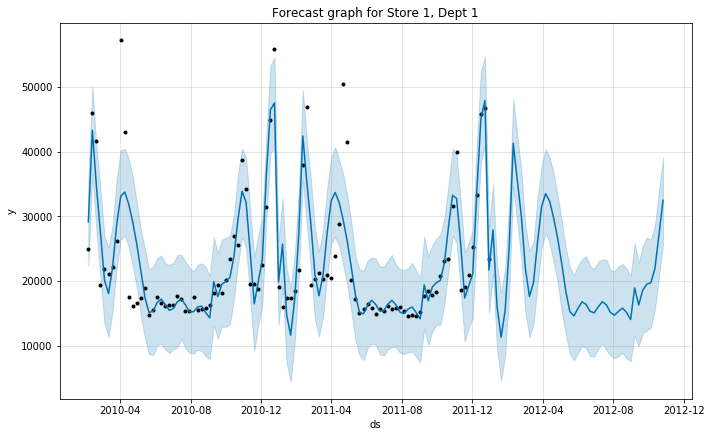

In [26]:
for store_dept, model_values in list(prophet_1.items()):   
    model_values[2].plot(model_values[3]) #### This is model.plot(forecast)
    plt.title("Forecast graph for Store %d, Dept %d" %(store_dept[0], store_dept[1])) 

Above graph shows that the Forecasted values (blue line) are along the Observed values (black dots).

### Model Summary results and Diagnostics - ARIMA

                                 Statespace Model Results                                 
Dep. Variable:                       Weekly_Sales   No. Observations:                  100
Model:             SARIMAX(1, 1, 1)x(0, 1, 0, 52)   Log Likelihood                -493.865
Date:                            Sun, 25 Feb 2018   AIC                            993.731
Time:                                    23:06:54   BIC                           1001.546
Sample:                                02-05-2010   HQIC                           996.894
                                     - 12-30-2011                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6455      0.128      5.060      0.000       0.395       0.896
ma.L1         -0.9028      0.062   

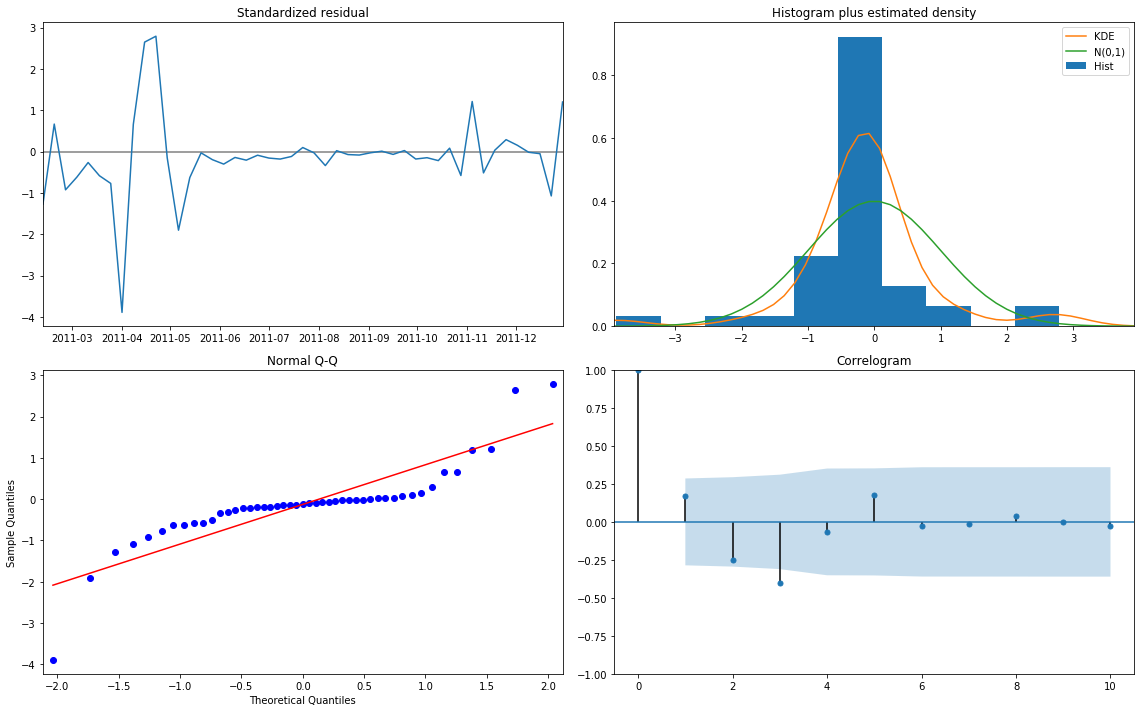

In [27]:
for k, v in forecast_result.items():
    print(v[2].summary())
    v[2].plot_diagnostics(figsize=(16,10))
    plt.tight_layout()

### Observed vs Forecast - ARIMA

In [28]:
## Plot the y_train (observed) and the predicted (forecast)
y = alldata[(alldata['Store']==1) & (alldata['Dept']==1)][['Weekly_Sales']]
train_size = int(len(y) * 0.70)
y_train, y_test = y[0:train_size], y[train_size:len(y)]

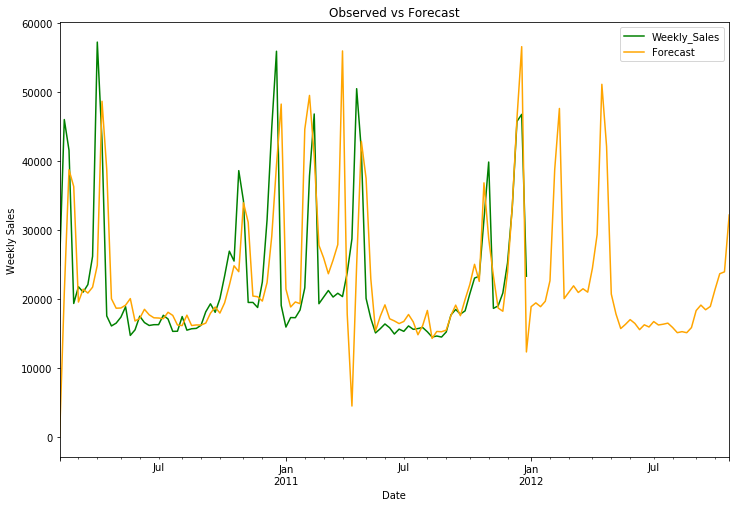

In [29]:
for k, v in forecast_result.items():
    y_train.plot(figsize=(12,8),color='green',label='Observed')
    v[3].plot(figsize=(12,8),color='orange',label='Forecast')
    plt.ylabel('Weekly Sales')
    plt.title('Observed vs Forecast')
    plt.legend(loc='best');

### Compare the MAE between Prophet and ARIMA

In [30]:
prophet_results = pd.read_csv('fbprophet_results.csv')
arima_results = pd.read_csv('arima_results.csv')

In [31]:
prophet_results['Model'] = 'Prophet'
arima_results['Model'] = 'ARIMA'

In [32]:
Results = pd.concat([prophet_results,arima_results])
Results_MAE = Results.groupby(['Store', 'Model'])[['MAE']].sum()
MAE_df = Results_MAE.pivot_table(index=['Store'], columns='Model', values='MAE')

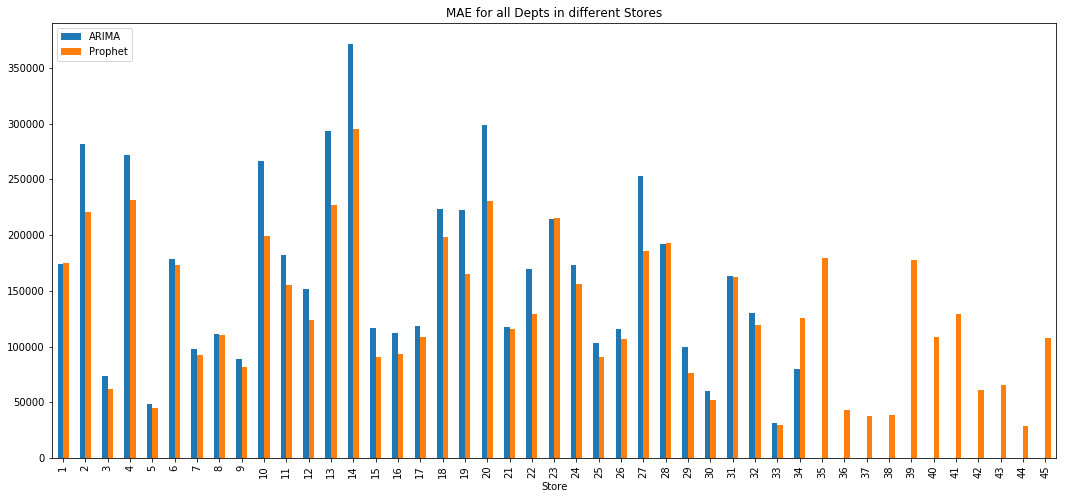

In [33]:
MAE_df.plot(kind='bar',figsize=(18,8),title='MAE for all Depts in different Stores')
plt.legend(loc='upper left');

The RMSE and MAE is captured for both the models for all stores and departments. 

It is clear that the RMSE and MAE of the Prophet forecast model are smaller when compared to the ARIMA model. 

So the Prophet forecasting model appears to be more accurate than the ARIMA.

### Conclusion

The results of Prophet model is overall better compared to the ARIMA model. 

However some departments in Prophet with model show a relatively high MAE, namely departments 38, 72. 

It would be better to consult the product manager to get more information on these departments. 

Moreover, Prophet works easily with holidays/shifting events, and is robust to missing data, shifts in trend, while the ARIMA model does not produce good pdq's to create a model.

We can try to modify the parameters we have used for ARIMA, to see if there is an improvement in the fit.

Overall, with the current results, we can conclude that the __Prophet__ is a better model to use.